# Introducing Classification

### Part 1:

- Let's introduce the notion of a binary classifier
- Simple threshold
- Metrics
- The ROC Curve, Precision-Recall Curve

### Part 2

- Introduce MNIST letters
- Train some scikit-learn classifiers
- Cross validation on training data
- Characterize performance
- Metrics, again
- The ROC Curve, Precision-Recall Curve, again

### Part 3

- Notion of linear classifiers
- Naive Bayes Classifier (next notebook)

## Part 1: Simple Binary Classification

Consider the following canonical example:

- We have a biomarker that can be used as a proxy for disease
- From a sample of patients and controls, we obtain two distributions of the biomarker.
- The biomarker, let's say it is unit of mols/L, is our only **feature/predictor**
- Our **output/label** is presence of disease, a categorical variable with only two possible values

We ask, can we reliably classify patients?

We will approach this problem using a simple threshold: This is the simplest possible (I think) example of a linear classifier

Our task is simply to choose an optimal cutoff for classifying as diseased vs. not diseased

This simple task allows us to (re-)introduce several metrics in a (hopefully) intuitive way:

- Accuracy
- No-information rate
- Sensitivity (TPR, Recall)
- Specificity (TNR)
- Confusion Matrix
- ROC Curve
- Precision-Recall Curve
- Positive predictive value (precision)
- Negative predictive value
  
We will examine how performance varies in balanced vs. unbalanced (skewed) patient sets

#### Let's simulate some results in a hypothetical patient population...

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
#We will impose disease prevalence, and the number of healthy patients
####

#N1 = Number without disease
#prev = disease prevalence
def get_distributions(prev=.5, N1=1000, mean_no_dz = 10, sd_no_dz=2, mean_dz = 14, sd_dz=2):

    N2 = int(N1 * prev / (1 - prev))

    no_dz_level = np.random.normal(mean_no_dz, sd_no_dz, N1)
    dz_level = np.random.normal(mean_dz, sd_dz, N2)
    
    #Make an array of 0s in first column, biomarker in second
    dz_array = np.array([np.zeros([N1,]), no_dz_level]).T
    
    #Array of 1s in first column, biomarker in second
    no_dz_array = np.array([np.ones([N2,]), dz_level]).T
    
                    
    #Put it into a DataFrame:
    df = pd.DataFrame(np.vstack((dz_array, no_dz_array)), columns = ['disease', 'marker'])

    #Return the distributions and the DataFrame
    return no_dz_level, dz_level, df

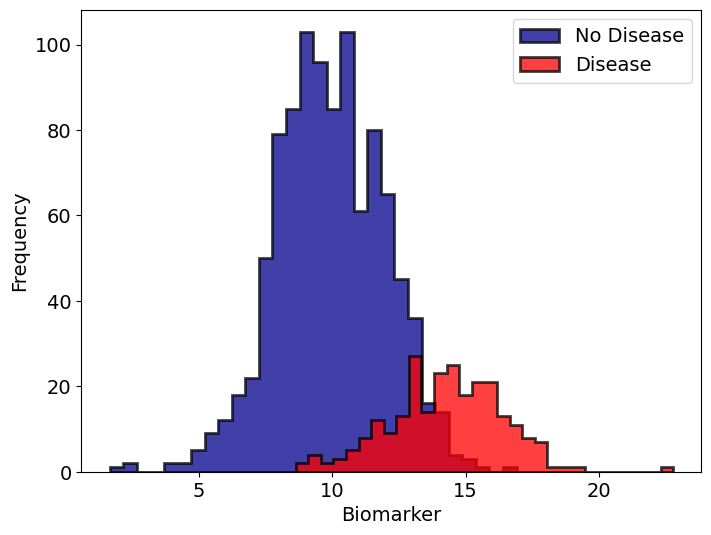

In [68]:
#Get our arrays for no disease, disease, and both in a DataFrame:
########

no_dz_level, dz_level, df = get_distributions(prev=.2)


#Plot how these distributions compare:
########

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

ax1.hist(no_dz_level, bins = 30, rwidth = .8, facecolor='darkblue', \
                edgecolor='black', linewidth = 2, alpha=0.75, label='No Disease', histtype='stepfilled');

ax1.hist(dz_level, bins = 30, rwidth = .8, facecolor='red', \
                edgecolor='black', linewidth = 2, alpha=0.75, label='Disease', histtype='stepfilled');

fs = 14
ax1.set_xlabel('Biomarker', fontsize=fs)
ax1.set_ylabel('Frequency', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.legend(fontsize=fs);

In [69]:
#Check the DataFrame:
display(df.head())
df.tail()

,disease,marker
0,0.0,7.354718
1,0.0,11.538774
2,0.0,8.847451
3,0.0,13.370388
4,0.0,10.373740


,disease,marker
1245,1.0,11.552882
1246,1.0,16.519609
1247,1.0,14.133428
1248,1.0,13.249922
1249,1.0,15.300311


### Set a Threshold, Calculate Metrics

Let's set a threshold for classification. Then we will calculate the following:

- True positives
- True negatives
- False positives
- False negatives
 
 ---
 
- True positive rate (TPR)
- True negative rate (TNR)

---

- Accuracy
- No-information rate

---

- Positive predictive value (PPV, Precision)
- Negative predictive value (NPV, Precision)

#### Good Practice: Train/Test split!

- This is a simple setting, but good to remind ourselves to always train/test split
- And split into features/labels (inputs/outputs)

In [70]:
from sklearn.model_selection import train_test_split

#X and y are quite simple here!
X = df[['marker']]
y = df[['disease']]

#Do a simple random train/test split:
#Let's keep 30% of the data for testing
#####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [82]:
##And let's make a "Classifier:" We'll just pass a threshold:
##########

from sklearn.utils.validation import check_array

class SimpleClassifier:
    def __init__(self, threshold=1):
        self.threshold = threshold

    def classify(self, X):
        X = check_array(X)
        
        #Make zeros in shape of X: 
        self.y_pred_ = np.zeros_like(X)

        #Just make 1s everywhere we exceed the threshold:
        self.y_pred_ = (X > self.threshold).astype(int)

        return self.y_pred_

    #Calculate our standard metrics
    def calc_metrics(self, y_true, y_pred):
        #Calculate a bunch of metrics:
        y_true = check_array(y_true)
        y_pred = check_array(y_pred)

        #True positives
        self.TP_ = np.sum(((y_true == y_pred) & (y_true == 1)).astype(int))
        #True negatives
        self.TN_ = np.sum(((y_true == y_pred) & (y_true == 0)).astype(int))

        #False positives
        self.FP_ = np.sum(((y_true != y_pred) & (y_pred == 1)).astype(int))
        #False negatives
        self.FN_ = np.sum(((y_true != y_pred) & (y_pred == 0)).astype(int))
        
        #True positive rate:
        self.TPR_ = self.TP_ / (self.TP_ + self.FN_)
        #True negative rate:
        self.TNR_ = self.TN_ / (self.TN_ + self.FP_)
        
        
        #Accuracy: Just the proportion correctly classified
        self.accuracy_ = (self.TP_ + self.TN_) / (self.TP_ + self.FN_ + self.TN_ + self.FP_)
        
        #And no-information rate: The best we could do from chance alone:
        #Get the counts of each unique element of y_true:
        values, counts = np.unique(y_true, return_counts=True)
        self.no_info_rate_ = np.max(counts) / np.sum(counts)

        
        #Finally, PPV and NPV:
        #Only calculate if any true positives or any true negatives
        if (self.TP_ > 0):
            self.PPV_ = self.TP_ / (self.TP_ + self.FP_)
        else:
            self.PPV_ = 1
            
        if (self.TN_ > 0):
            self.NPV_ = self.TN_ / (self.TN_ + self.FN_)
        else:
            self.NPV_ = 1

In [83]:
#Make a classifier:
pt_classifier = SimpleClassifier(threshold=12.5)

#Get predictions:
y_pred = pt_classifier.classify(X_train)

pt_classifier.calc_metrics(y_train, y_pred)

print(pt_classifier.TPR_)
print(pt_classifier.TNR_)

0.8176795580110497
0.8933717579250721


In [73]:
#PPV_ and NPV_:
print(pt_classifier.PPV_)
print(pt_classifier.NPV_)

0.6666666666666666
0.9494640122511485


In [74]:
#Accuracy and NIR:
print(pt_classifier.accuracy_)
print(pt_classifier.no_info_rate_)

0.8777142857142857
0.7931428571428571


In [75]:
## Can get the confusion matrix from sklearn:
from sklearn.metrics import confusion_matrix

#Format is:
# [TN, FP]
# [FN, TP]

cm = confusion_matrix(y_train, y_pred)

print(cm, '\n')

#So, TPR = TP / (TP + FN) is
print(cm[1,1] / (cm[1,1] + cm[1,0]))

#TNR = TN / (TN + FP)
print(cm[0,0] / (cm[0,0] + cm[0,1]))


[[620  74]
 [ 33 148]] 

0.8176795580110497
0.8933717579250721


In [76]:
## Accuracy is just the fraction that are correctly classified:
## (TP + TN) / (TP + TN + FP + FN)

##Also have a scikit-learn option:

#See for list of options: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
from sklearn import metrics

metrics.accuracy_score(y_train, y_pred)

0.8777142857142857

In [77]:
## We can get a few metrics all together:
########
#F1 score is harmonic mean of precision and recall, which we'll get to in a moment

#Need to print or it looks wonky
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       694
         1.0       0.67      0.82      0.73       181

    accuracy                           0.88       875
   macro avg       0.81      0.86      0.83       875
weighted avg       0.89      0.88      0.88       875



## Build an ROC Curve

- Plot TPR against (1 - TNR) for all thresholds...

In [103]:
#Get data again:
no_dz_level, dz_level, df = get_distributions(prev=.5, N1=5000)

X = df[['marker']]
y = df[['disease']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


In [104]:
#Get a ROC Curve
################

#Iterate through threshold values
num_vals = 100

thresh_array = np.linspace(0, 20, num_vals)

TPR = np.zeros((num_vals,))
TNR = np.zeros((num_vals,))

#Also save PPV
PPV = np.zeros((num_vals,))


for k in range(num_vals):

    pt_classifier.threshold = thresh_array[k]

    y_pred = pt_classifier.classify(X_train)
    pt_classifier.calc_metrics(y_train, y_pred)
    
    #Get True Positive Rate = TP / (TP + FN)
    TPR[k] = pt_classifier.TPR_

    #Get True Negative Rate = TN / (TN + FP) = Specificity
    TNR[k] = pt_classifier.TNR_

    #PPV:
    PPV[k] = pt_classifier.PPV_
    
Y = TPR
X = 1 - TNR

#Get closest to upper left
d_min = 999999999
for k in range(num_vals):

    #Euclidean distance to upper left:
    d = np.sqrt((0 - X[k])**2 + (1 - Y[k])**2)

    if (d < d_min):
        d_min = d 
        k_opt = k


#Get first with 100% sensitivity
k_100sens = num_vals-1
for k in range(num_vals-1,0,-1):
    if (Y[k] == 1):
        k_100sens = k
        break

#Get first with 100% specificity
k_100spec = 0
for k in range(0,num_vals,1):
    if (X[k] == 0):
        k_100spec = k
        break

Best Threshold =  12.121212121212121
AUC =  0.9208852401545935
Sensitivity =  0.8357364998586373
Specificity =  0.855038983540283


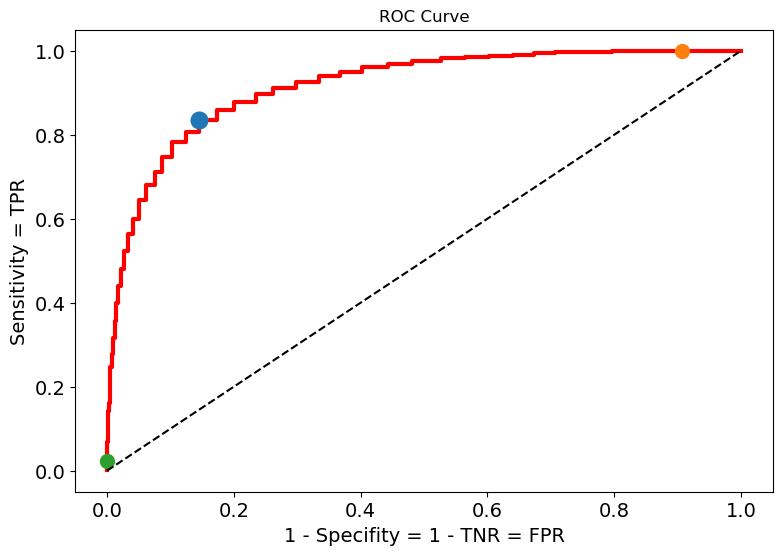

In [105]:
#Plot results: ROC Curve
#############

fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(1-TNR, TPR, color="red", linewidth=3)

ax1.plot(1 - TNR[k_opt], TPR[k_opt], 'o', markersize=12)
ax1.plot(1 - TNR[k_100sens], TPR[k_100sens], 'o', markersize=10)
ax1.plot(1 - TNR[k_100spec], TPR[k_100spec], 'o', markersize=10)

ax1.plot([0,1], [0,1], '--', color = 'black')


fs = 14
ax1.set_xlabel('1 - Specifity = 1 - TNR = FPR', fontsize=fs)
ax1.set_ylabel('Sensitivity = TPR', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('ROC Curve')

#Calculate AUC:
AUC = np.trapz(TPR, TNR)


print('Best Threshold = ', thresh_array[k_opt])
print('AUC = ', AUC)


#Sensitivity/Specificity
print('Sensitivity = ', TPR[k_opt])  #Sensitivity
print('Specificity = ', TNR[k_opt])  #Specificity

### And a Precision-Recall Curve

- Precision = PPV
- Recall = TPR = Sensitivity

(More on this below)

(0.0, 1.0)

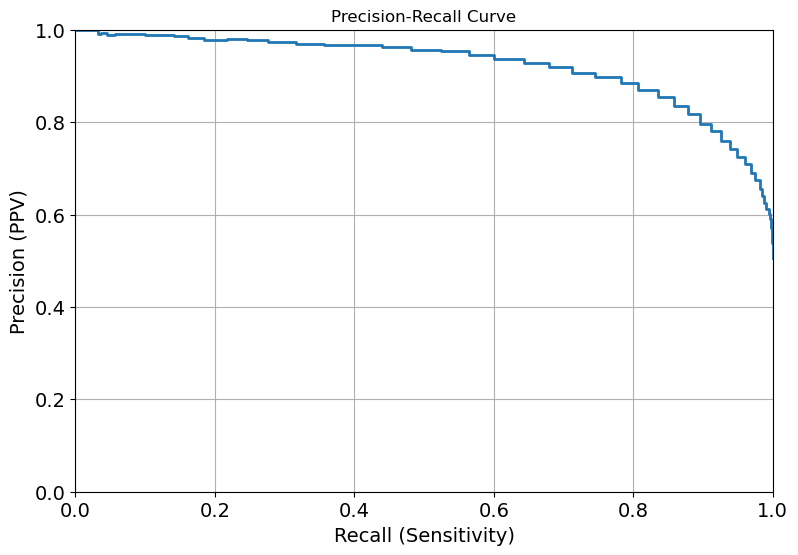

In [106]:
fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))


#Recall = TPR
#Precision = PPV
ax1.step(TPR, PPV, linewidth=2)
ax1.grid()


#Axis labels, etc.
fs = 14
ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Precision-Recall Curve')
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])

## Part 2. MNIST Dataset and some Scikit-Learn Classifiers

- Introducing the "Hello World" of Machine Learning...

- A couple ways to get:

In [107]:
from keras.datasets import mnist

#We'll get 60,000 train images and 10,000 test images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [108]:
#What have we? Let's start with shape:
#60000 28x28 training images for the train set
X_train.shape

(60000, 28, 28)

In [109]:
##Labels?
print(y_train.shape)
print(np.unique(y_train))

(60000,)
[0 1 2 3 4 5 6 7 8 9]


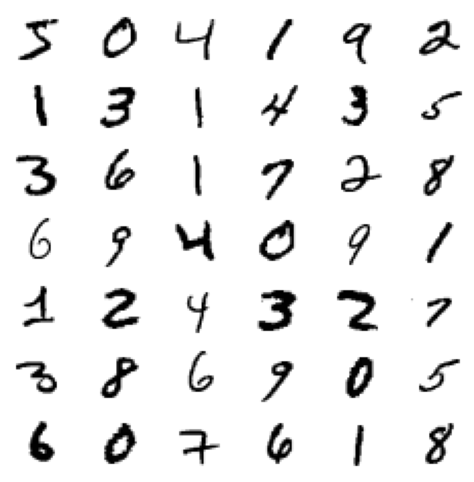

In [110]:
#Plot the first few training images:
#######

fig1, ax1 = plt.subplots(7, 6, figsize=(6,6))

#Flatten for easier indexing
ax1 = ax1.flatten()

#And plot:
for i in range(42):

    im = ax1[i].imshow(X_train[i], cmap='gray_r')
    ax1[i].set_axis_off()
    #fig1.colorbar(im,  ax=ax1[i], orientation='vertical')

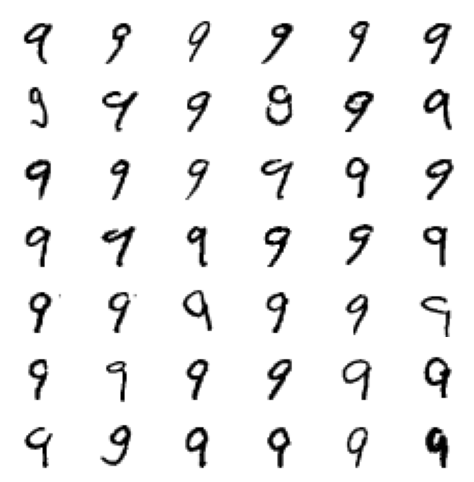

In [111]:
###And plot a bunch of whatever number:
########

#Plot the first few training images:
#######

#Grab all the 0s, 1s, 2s, etc.
train_images_specific_num = X_train[y_train == 9]

fig1, ax1 = plt.subplots(7, 6, figsize=(6,6))

#Flatten for easier indexing
ax1 = ax1.flatten()

#And plot:
for i in range(42):

    im = ax1[i].imshow(train_images_specific_num[i], cmap='gray_r')
    ax1[i].set_axis_off()    

### Make Binary: Tag everything as either "5" or "not 5"; Train with `SGDClassifier`

- We will make a classifier to detect 5 vs non-5
- We'll train the model and assess performance on the training set using cross-validation

Start with `sklearn.linear_model.SGDClassifier`. Implements either:

1. Logistic Regression Classifier
2. Support Vector Machine (SVM) Classifier (default)

These are *linear* classifiers: Our data space is partitioned by a linear hyperplane
- Point in 1-D, i.e. single cutoff
- Line in 2-D
- Plane in 3-D
- Hyperplane in higher dimensions

Some key parameters:

1. `loss{‘hinge’, ‘log_loss’, ...}, default=’hinge’`

    - `hinge` = Default implies SVD classifier
    - `log_loss` implies logistic regression


2. `penalty{‘l2’, ‘l1’, ‘elasticnet’, None}, default=’l2’`
   
    Regularization to (hopefully) avoid overfitting


Finally: **Model is trained** using the stochastic gradient descent: Minimizes loss term by following error gradient downhill, stochastically selects sample for each error calculation


#### Reshape the input:

Our classifier expects 2-D data (rows of observations) for the training dat

But our training data shape?

In [112]:
X_train.shape

(60000, 28, 28)

In [113]:
#Need to flatten/reshape:
###

X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [114]:
## Make our binary data:
#####

#Need only tag the output; input stays the same!
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [115]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [116]:
#Get the classifier
from sklearn.linear_model import SGDClassifier

#Recall paradigm: Construct the estimator, independent of data
sgd_clf = SGDClassifier(random_state=42)

#Now, we fit the estimator:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [122]:
## This estimator is a *predictor* (and not a transformer), so we can predict some output:
###

#To get a single digit, and reshape it to the 784 x 1 that the classifier expects:
#Either of the following work:
#X_train[0,:].reshape(-1,1).T
#X_train[[0],:]

## Prediction on the first number?
sgd_clf.predict(X_train[[0],:])

array([ True])

In [123]:
#Reality?
y_train_5[0]

True

In [124]:
#First few predictions?
sgd_clf.predict(X_train[:20,:])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False])

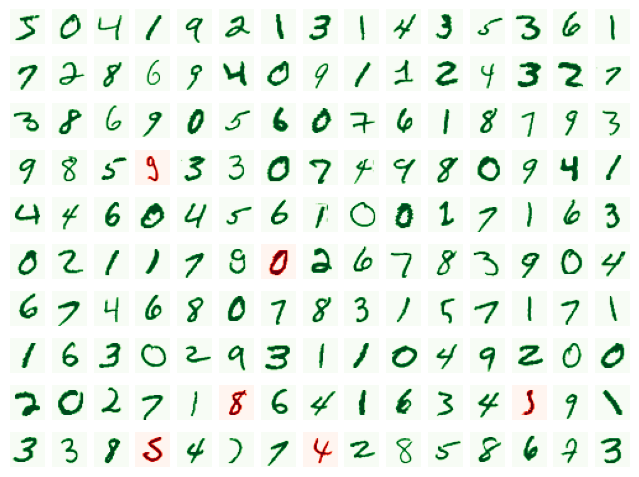

In [128]:
### Let's display the first echelon of predictions...
#########
fig1, ax1 = plt.subplots(10, 15, figsize=(8,6))
#Flatten for easier indexing
ax1 = ax1.flatten()

y_pred = sgd_clf.predict(X_train[:150,:])

#And plot:
for i in range(150):

    #Color differently if correct vs. incorrect prediction:
    if (y_pred[i] == y_train_5[i]):
        my_cmap = 'Greens'
    else:
        my_cmap = 'Reds'

    #Now we need to reshape back to 28x28 for plotting
    ax1[i].imshow(X_train[i].reshape(28,28), cmap=my_cmap)
    ax1[i].set_axis_off()


### Assess Performance: Accuracy

- Let's check out accuracy
- You should already note that the this is an unbalanced dataset, so accuracy is suspect

In [129]:
## Recall Accuracy is just the fraction that are correctly classified:
## (TP + TN) / (TP + TN + FP + FN)

#To do ourselves:
y_pred = sgd_clf.predict(X_train)
(y_pred == y_train_5).sum() / (len(y_train_5))

0.9522666666666667

In [130]:
##Accuracy is the score reported by the `score()` method, which all predictors have:
#Pass the test dataset, followed by the labels:
sgd_clf.score(X_train, y_train_5)

0.9522666666666667

In [131]:
#Or with scikit-learn metrics
#Reimport to remind us
from sklearn import metrics

#Confirm we got the same thing
metrics.accuracy_score(y_pred, y_train_5)

0.9522666666666667

### Accuracy under Cross-Validation

- Recall the notion of k-fold cross-validation
- Easy with `cross_val_score`

In [132]:
#Just use 3 folds for speed
###

from sklearn.model_selection import cross_val_score

cross_val_accuracies = cross_val_score(sgd_clf, X_train, y_train_5,
                              scoring="accuracy", cv=3)

cross_val_accuracies

array([0.95035, 0.96035, 0.9604 ])

In [133]:
#Over 95% accuracy even under cross-validation, hooray (right?)
np.mean(cross_val_accuracies)

0.9570333333333334

#### No-information Rate?

- This is the accuracy if we simply labelled the output as the most common class
- This would be the best we could do by chance alone

Can do manually:

In [137]:
#One way:
#Try y_train_5 vs y_train
values, counts = np.unique(y_train_5, return_counts=True)

print(values)
print(counts)

[False  True]
[54579  5421]


In [138]:
#Give us the index of the largest value in counts:
counts.argmax()

0

In [139]:
#And extract the most common label?
values[counts.argmax()]

#Or: But might not be unique
#values[counts == counts.max()]


False

In [140]:
## Finally, no-information rate is accuracy if we just guessed the most common label:
####

#So, could get 90% by just guessing that a given number is not a 5! Makes intuitive sense
counts.max() / counts.sum()

0.90965

#### Can also use a `DummyClassifier`

In [141]:
from sklearn.dummy import DummyClassifier

#Create
dummy_clf = DummyClassifier()

#Fit
dummy_clf.fit(X_train, y_train_5)

#Predict:
dummy_clf.predict(X_train)

array([False, False, False, ..., False, False, False])

In [142]:
#Is it all Falses?
#Yep!
np.all(~dummy_clf.predict(X_train))

True

In [143]:
#Accuracy of the dummy predictor?
dummy_clf.score(X_train, y_train_5)

0.90965

In [144]:
## And under cross-validation?
#####

from sklearn.model_selection import cross_val_score

cross_val_accuracies = cross_val_score(dummy_clf, X_train, y_train_5,
                              scoring="accuracy", cv=3)

cross_val_accuracies

array([0.90965, 0.90965, 0.90965])

### Confusion Matrix and Prediction with Cross-Validation

Recall that the confusion matrix can be expressed as:

$$
\begin{pmatrix}
\text{True Negatives} & \text{False Positives} \\
\text{False Negatives} & \text{True Positives}
\end{pmatrix}
$$


That is, each row represents the *actual* class, and each column is the *predicted* class. So the first row is the actual negatives. If we predict a negative (first column, first row), then that's correct, a true negative. If we predict a positive (second column, first row), well that's a false positive.

Similarly, the second row is actual positives. Predicting a negative is a false negative (first column, second row); predicting a positive is a true positive!

#### Prediction with cross-validation

- We can get out-of-sample predictions on the training dataset by using cross-validation, pretty cool huh?

- We just compile the predictions on each fold (so the model was trained on the other $k-1$ folds). Are you shocked that there is a Scikit-Learn class that does this? `cross_val_predict`

In [145]:
#Get pridctions using cross-validation:
from sklearn.model_selection import cross_val_predict

#3 folds for brevity
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [146]:
## Confirm shape is correct
y_train_pred.shape

(60000,)

In [150]:
#We'll just use the sklearn confusion_matrix:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [151]:
## Compare to perfection:
######
cm_perfect = confusion_matrix(y_train_5, y_train_5)
cm_perfect

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Sensitivity and specificity?

- Alas, these we must calculate manually!

In [152]:
#Sensitivity = TPR = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
sensitivity

0.6511713705958311

In [153]:
#Specifity = TNR = TN / (TN + FP)
specifity = cm[0,0] / (cm[0,0] + cm[0,1])
specifity

0.987412741164184

### Make a ROC Curve: Need score for each prediction and threshold

- The model internally generates a score for how likely a number is to be a 5 (in this case)
- Use a threshold to make a decision

#### Can use `decision_function()` to get scores:

In [154]:
#Some scores:
#####

sgd_clf.decision_function(X_train[:10,:])

array([  2164.22030239,  -5897.37359354, -13489.14805779,  -4623.84515943,
        -6873.05248453,  -3908.27576291,  -4851.9422397 ,  -4988.52407755,
        -2226.78132866,  -4081.33692831])

#### Cross-validated scores:

In [155]:
#Change method to decision_function:
######

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [156]:
## Let's sort by score and plot: For first 150
##########

##We'll make a Series and take advantage of the index for this:
s = pd.Series(y_scores[:150])
s

0       1200.930512
1     -26883.792024
2     -33072.034754
3     -15919.548069
4     -20003.539702
           ...     
145     3684.637045
146   -14726.263445
147   -22085.243665
148   -22825.817711
149   -24449.733592
Length: 150, dtype: float64

In [157]:
#Now, if we sort by value, we'll preserve the index for plotting:
s = s.sort_values()
s

28    -55517.284362
20    -49309.774768
114   -45440.426371
63    -45082.921783
108   -41602.379473
           ...     
0       1200.930512
35      2128.094446
145     3684.637045
65      5577.271020
47      7218.005784
Length: 150, dtype: float64

In [158]:
#To get the index:
s.iloc[[0]].index[0]

28

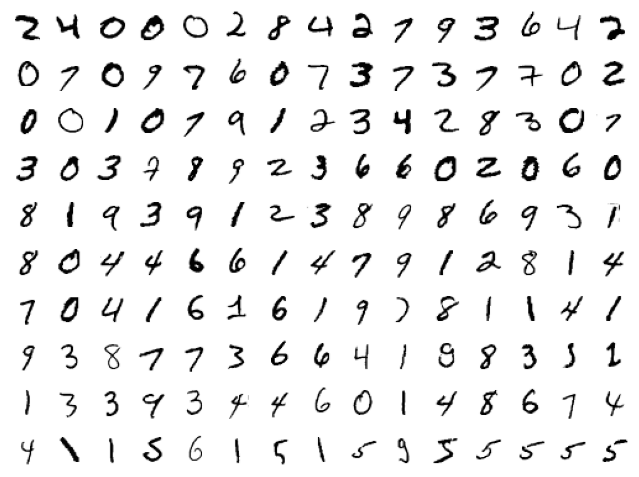

In [160]:
### Plot from low to high score:
fig1, ax1 = plt.subplots(10, 15, figsize=(8,6))
#Flatten for easier indexing
ax1 = ax1.flatten()

#And plot:
for i in range(150):
    #Now we need to reshape back to 28x28 for plotting
    #And we get the index from s:
    ax1[i].imshow(X_train[s.iloc[[i]].index[0]].reshape(28,28), cmap='Greys')
    ax1[i].set_axis_off()


### ROC Curve? Systematically vary threshold

- Systematically vary threshold
- Calculate FPR, TPR for each

In [161]:
#Have our scores from above:
#y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
#                            method="decision_function")
#y_scores

#Can make now with scikit-learn:
from sklearn.metrics import roc_curve

#FPR is 1 - TNR
FPR, TPR, thresholds = roc_curve(y_train_5, y_scores)

In [163]:
#Can see that thresholds get larger as we go to the left
#So, a high threshold means lower sensitivity but higher specificity: That is, lower true positive rate, but higher true negative rate
thresholds

array([             inf,   49441.43765905,   36801.60697028, ...,
       -105763.22240074, -106527.45300471, -146348.56726174])

In [164]:
Y = TPR
X = FPR

#Get closest to upper left
d_min = 999999999
for k in range(len(thresholds)):

    #Euclidean distance to upper left:
    d = np.sqrt((0 - X[k])**2 + (1 - Y[k])**2)

    if (d < d_min):
        d_min = d 
        k_opt = k

#Optimal threshold value?
thresholds[k_opt]

-7159.414796533757

Sensitivity =  0.9070282235749861
Specificity =  0.9099653712966526


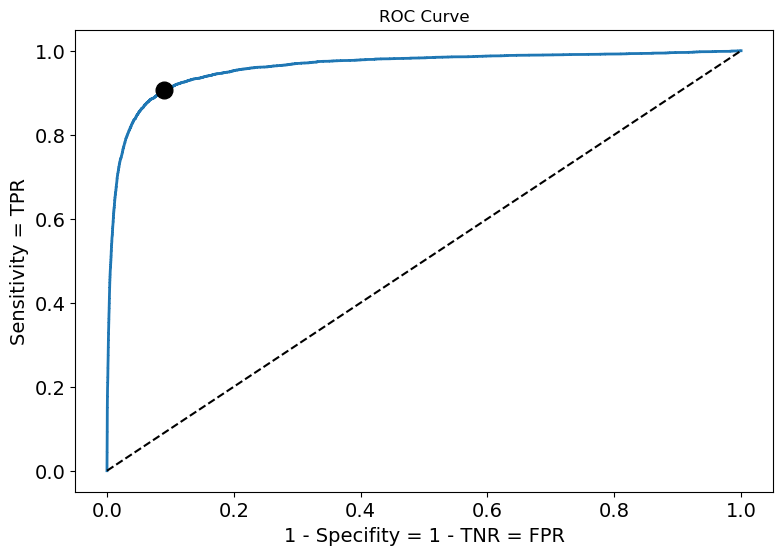

In [165]:
#Plot this ROC Curve
#############

fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(FPR, TPR, linewidth=2)

#Optimal threshold?
ax1.plot(FPR[k_opt], TPR[k_opt], 'o', markersize=12, color='black')
ax1.plot([0,1], [0,1], '--', color = 'black')


fs = 14
ax1.set_xlabel('1 - Specifity = 1 - TNR = FPR', fontsize=fs)
ax1.set_ylabel('Sensitivity = TPR', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('ROC Curve')

#Calculate AUC:
#y, x
AUC = np.trapz(TPR, FPR)
AUC

#Sensitivity/Specificity
print('Sensitivity = ', TPR[k_opt])  #Sensitivity
print('Specificity = ', 1 - FPR[k_opt])  #Specificity

In [166]:
##This gives a different sensitivity/specificity balance compared to above
##Check against default threshold of 0:
idx = (thresholds <= 0).argmax()

#Sensitivity/Specificity
print('Sensitivity = ', TPR[idx])  #Sensitivity
print('Specificity = ', 1 - FPR[idx])  #Specificity

Sensitivity =  0.6515403062165652
Specificity =  0.987412741164184


### Precision + Recall

**Precision** = Accuracy of positive predictions = **postive predictive value**

$$
\text{Precision} = P(\text{Actual Positive} \, | \, \text{Predict Positive}) = \frac{TP}{TP + FP}
$$

- Depends upon data, will go down with more unbalanced dataset

***A trivially perfect precision?***

Always predict negative, except for the one instance we are most certain of. If this is correct, then the probability of an actual positive, given a predicted positive, is 1.

    - However, very low probability of predicting a positive in the case of an actual positive
    - Ideally would have a high probability of predicting positive, given an actual positive, as well

Hence, **Recall**:

**Recall** = **Sensitivity** = **TPR** 

$$
\text{Recall} = P(\text{Predict Positive} \, | \, \text{Actual Positive}) = \frac{TP}{TP + FN}
$$

Tradeoff as illustred by the Geron text:

<img src="precision_recall_illustrated.png" alt="Precision-Recuall" style="width:550px;"/>


#### Given the confusion matrix, it is straightforward to calculate precision and recall

But of course, Scikit-learn gives us some functions:

In [167]:
from sklearn.metrics import confusion_matrix

#Recall we had our cross-validation predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [168]:
#Precision =  TP / (TP + FP)
cm[1,1] / (cm[1,1] + cm[0,1])

0.8370879772350012

In [169]:
#Recall =  TP / (TP + FN)
cm[1,1] / (cm[1,1] + cm[1,0])

0.6511713705958311

In [170]:
#Scikit-learn way
#####

from sklearn.metrics import precision_score, recall_score

##Confirm precision
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [171]:
##Confirm recall
recall_score(y_train_5, y_train_pred)

0.6511713705958311

### $F_1$ Score

Since we'd like to have both good precision (positive predictive value, i.e. confidence a predicted positive is a true positive) and good recall (confidence that actual positives will be predicted as such), we can combine the two into the $F_1$ score:

$F_1$ score = *harmonic mean* of precision and recall; gives more weight to low values

Defined as:

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}= 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

Compute:

In [172]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Note: $F_1$ Favors classifiers with similar precision and recall

- Similar to choosing an optimal threshold with the ROC curve, we may want to favor precision over recall, or visa versa

**1.** Consider disease *screening* test: Want high *recall = sensitivity*. That is, want to detect most of the actual positives. However, most will not be true positives (low precision) but that's okay: We send for confirmatory testing

A confirmatory test should be highly specific to the disease being tested, and should also have high precision (and really, we want good recall/sensitivity too!)

**2.** Or consider the legal classification: Guilty vs. Not Guilty. It is generally agreed we want very high precision (positive predictive value), even at the expense of low recall: If you are deemed guilty, we must be near certain, even if many guilty cases are missed ("better to let 10 guilty go free than to jail one innocent").

### Precision-Recall Tradeoff

Graphically, notion is:

<img src="precision_recall_tradeoff.png" alt="Precision-Recuall" style="width:550px;"/>


- Similar to ROC curve, we systematically change decision threshold and log the results

- Can do:

In [173]:
#Grab our scores again
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [174]:
#Are you shocked there is a function for this?
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#### Precision-Recall Curve:

In [179]:
#Find the index where thresholds first exceed 0 (or some other value):
thresh = 0

#Best threshold based on ROC curve:
thresh = -7159.414796533757

#argmax gives the index of maximum argument: If there are multiple equal maxes, gives the first
#Since 1 = True is the maximum, this is a shortcut to index for first True
idx = (thresholds >= thresh).argmax()


In [180]:
#a = np.array([1,2,3,1,3])
#a.argmax()

(0.0, 1.0)

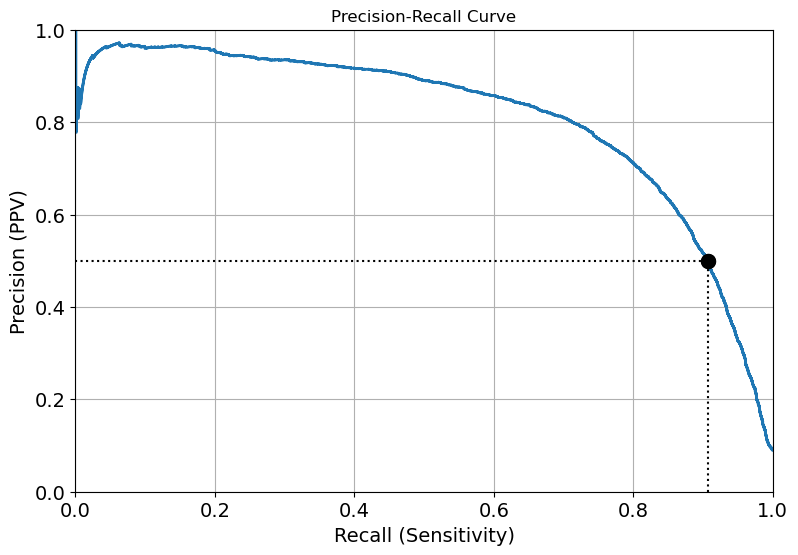

In [181]:
fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(recalls, precisions, linewidth=2)
ax1.grid()

#Add a line showing recall and precision for the given threshold above:
ax1.plot([recalls[idx], recalls[idx]], [0, precisions[idx]], "k:")
ax1.plot([0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")

#And the intersection:
ax1.plot([recalls[idx], recalls[idx]], [precisions[idx], precisions[idx]], "ko", markersize=10)


#Axis labels, etc.
fs = 14
ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Precision-Recall Curve')
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])

#### Alternative Visualization:


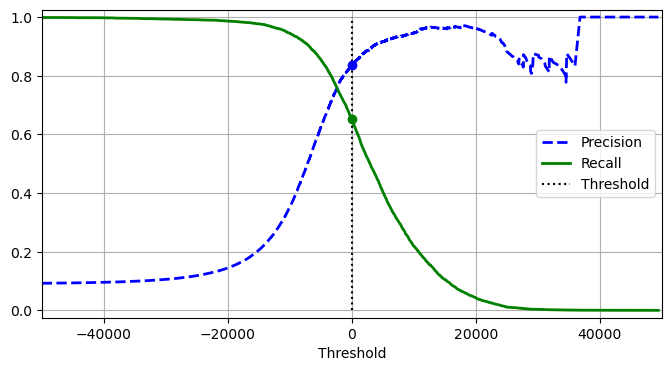

In [182]:
thresh=0
idx = (thresholds >= thresh).argmax()


#Adapted directly from book code:
fig1, ax1 = plt.subplots(1, 1, figsize=(8,4))

ax1.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
ax1.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

ax1.vlines(thresh, 0, 1.0, "k", "dotted", label="Threshold")

ax1.plot(thresholds[idx], precisions[idx], "bo")
ax1.plot(thresholds[idx], recalls[idx], "go")

ax1.grid()
ax1.set_xlabel("Threshold")
ax1.legend(loc="center right")

ax1.set_ylim([-.025, 1.025])
ax1.set_xlim([-50000, 50000]);


## Compare to a Random Forest Classifier


In [183]:
#Make our estimator
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [184]:
##Fit the model: Takes a moment
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

In [185]:
##Predictions on the training set:
######

y_pred_forest = forest_clf.predict(X_train)

#Whoa, perfect on the training set, clearly some overfitting
confusion_matrix(y_train_5, y_pred_forest)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [186]:
##Get cross-validation predictions instead: Takes a minute or so
#######
y_pred_forest_cv = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_pred_forest_cv

array([ True, False, False, ...,  True, False, False])

In [187]:
#Now, not so dramatic but still really good!
cm = confusion_matrix(y_train_5, y_pred_forest_cv)
cm

array([[54534,    45],
       [  725,  4696]], dtype=int64)

In [188]:
#Sensitivity = TPR = TP / (TP + FN)
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print(sensitivity)

#Specifity = TNR = TN / (TN + FP)
specifity = cm[0,0] / (cm[0,0] + cm[0,1])
specifity

0.8662608374838591


0.9991755070631562

In [189]:
#F1 Score
f1_score(y_train_5, y_pred_forest_cv)

0.9242275142688446

In [190]:
precision_score(y_train_5, y_pred_forest_cv)

0.9905083315756169

In [191]:
recall_score(y_train_5, y_pred_forest_cv)

0.8662608374838591

#### To get ROC curve and Precision-Recall curve:

Use `predict_proba` instead of `decision_function`:

In [192]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [193]:
#Note that we have two columns: (Predicted!) Probability of 0 vs 1
#We'll use the second column
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

Text(0.5, 1.0, 'ROC Curve')

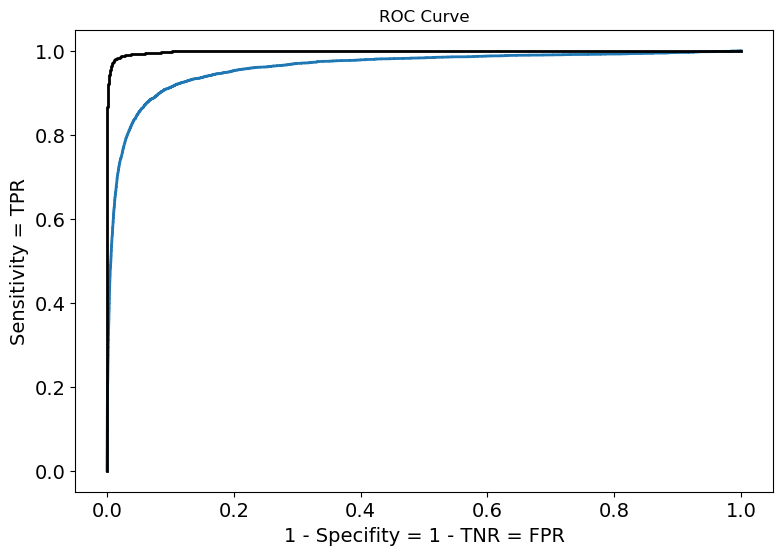

In [194]:
## ROC Curve: SGD vs. Random Forest:
#########

#y_scores from SGD above:
FPR1, TPR1, thresholds1 = roc_curve(y_train_5, y_scores)

#y_probas_forest here:
FPR2, TPR2, thresholds2 = roc_curve(y_train_5, y_probas_forest[:,1])

fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(FPR1, TPR1, linewidth=2)
ax1.step(FPR2, TPR2, linewidth=2, color='black')

fs = 14
ax1.set_xlabel('1 - Specifity = 1 - TNR = FPR', fontsize=fs)
ax1.set_ylabel('Sensitivity = TPR', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('ROC Curve')

In [195]:
## Upper left sens/spec for forest:
Y = TPR2
X = FPR2

#Get closest to upper left
d_min = 999999999
for k in range(len(thresholds2)):

    #Euclidean distance to upper left:
    d = np.sqrt((0 - X[k])**2 + (1 - Y[k])**2)

    if (d < d_min):
        d_min = d 
        k_opt = k
        
#Optimal threshold value?
print(thresholds2[k_opt])

#Sensitivity/Specificity
print('Sensitivity = ', TPR2[k_opt])  #Sensitivity
print('Specificity = ', 1 - FPR2[k_opt])  #Specificity


0.2
Sensitivity =  0.9809998155321896
Specificity =  0.9842063797431246


#### And Precision-Recall:

In [196]:
##Quick calc:
precisions2, recalls2, thresholds3 = precision_recall_curve(y_train_5, y_probas_forest[:,1])

(0.0, 1.0)

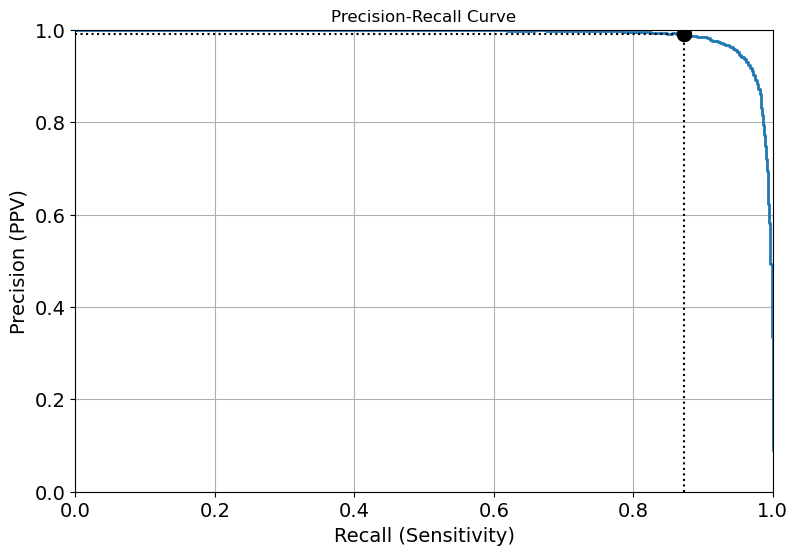

In [200]:
#0.5 is the default; We got 0.2 from the ROC curve
thresh=.2
thresh=.5

idx = (thresholds3 >= thresh).argmax()

fig1, ax1 = plt.subplots(1, 1, figsize=(9,6))

ax1.step(recalls2, precisions2, linewidth=2)
ax1.grid()

#Add a line showing recall and precision for the given threshold above:
ax1.plot([recalls2[idx], recalls2[idx]], [0, precisions2[idx]], "k:")
ax1.plot([0, recalls2[idx]], [precisions2[idx], precisions2[idx]], "k:")
#And the intersection:
ax1.plot([recalls2[idx], recalls2[idx]], [precisions2[idx], precisions2[idx]], "ko", markersize=10)


#Axis labels, etc.
fs = 14
ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Precision-Recall Curve')
ax1.set_ylim([0, 1])
ax1.set_xlim([0, 1])